In [1]:
import math
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, classification_report
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler, Subset
from torchvision import transforms as T

In [3]:
!pip install kaggle
!mkdir ~/.kaggle
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download -d gpiosenka/sports-classification
!unzip sports-classification.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
sports-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sports-classification.zip
replace EfficientNetB3-sports-0.97.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
None


In [3]:
class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=100):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(256, 100)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def DenseNet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

def DenseNet169():
    return DenseNet(Bottleneck, [6,12,32,32], growth_rate=32)

def DenseNet201():
    return DenseNet(Bottleneck, [6,12,48,32], growth_rate=32)

def DenseNet161():
    return DenseNet(Bottleneck, [6,12,36,24], growth_rate=48)

def densenet_cifar():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=12)

def test():
    net = densenet_cifar()
    x = torch.randn(1,3,32,32)
    y = net(x)
    print(y)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
std=torch.Tensor([0.4687, 0.4667, 0.4540])
mean=torch.Tensor([0.2792, 0.2717, 0.2852])
t_trans=T.Compose([
                 T.RandomHorizontalFlip(p=0.5),
                 T.RandomRotation(degrees=(0, 180)),
                 T.ToTensor(),
                 T.Normalize(mean,std)])
v_trans=T.Compose([
                   T.ToTensor(),
                   T.Normalize(mean,std)])
train_set=ImageFolder('./train',transform=t_trans)
valid_set=ImageFolder('./valid',transform=v_trans)
test_set=ImageFolder('./test',transform=v_trans)
valid_set=torch.utils.data.ConcatDataset([test_set, valid_set])
# indices = torch.randperm(len(train_set))[:5000]
# train_set = Subset(train_set,indices)
# indices = torch.randperm(len(valid_set))[:500]
# valid_set = Subset(valid_set,indices)

# Training

Inspired by: https://www.kaggle.com/code/edanurb/pytorch-model-99-acc?fbclid=IwAR2FZg7WuRk2m2WfoOXt33WIE5IoO3yVgnnp_grAMm9-Ep9Moy9JQZyiXCo and source code from labs

In [10]:
std=torch.Tensor([0.4687, 0.4667, 0.4540])
mean=torch.Tensor([0.2792, 0.2717, 0.2852])
t_trans=T.Compose([
                 T.RandomHorizontalFlip(p=0.5),
                 T.RandomRotation(degrees=(0, 180)),
                 T.ToTensor(),
                 T.Normalize(mean,std)])
v_trans=T.Compose([
                   T.ToTensor(),
                   T.Normalize(mean,std)])
train_set=ImageFolder('./train',transform=t_trans)
valid_set=ImageFolder('./valid',transform=v_trans)
test_set=ImageFolder('./test',transform=v_trans)
valid_set=torch.utils.data.ConcatDataset([test_set, valid_set])

In [3]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  return torch.device('cpu')

In [4]:
device=get_default_device()
device

device(type='cuda')

In [ ]:
train_loader = torch.utils.data.DataLoader(
      train_set,
      batch_size=32,
      num_workers=4,shuffle = True,
      drop_last=True)
test_loader = torch.utils.data.DataLoader(
    valid_set,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    drop_last=True)
lr = 0.01
model = DenseNet121().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)
loss_fn = nn.CrossEntropyLoss()

In [5]:
from collections import namedtuple
from itertools import product
import pandas as pd
import time
from collections import OrderedDict
import json
from IPython.display import clear_output

# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.loader_test = None

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader, loader_test):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    self.loader_test = loader_test

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.epoch_count = 0

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0

    self.epoch_loss_test = 0
    self.epoch_num_correct_test = 0

  # 
  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)

    accuracy_test = self.epoch_num_correct_test / len(self.loader_test.dataset)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["accuracy_test"] = accuracy_test
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait=True)
    display(df)

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  def track_num_correct_test(self, preds, labels):
    self.epoch_num_correct_test += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [8]:
import torch.nn as nn
import torch.optim as optim
import gc
epochs = 10
def searching_function(params2, return_model=False, network = None):
  m = RunManager()

  # get all runs from params using RunBuilder class
  for run in RunBuilder.get_runs(params2):
    
    # if params changes, following line of code should reflect the changes too
    if network is None:
      network = torchvision.models.densenet121()
      for param in network.parameters():
        param.required_grad = False
      network.classifier = nn.Linear(1024, 100)
    # network.fc = nn.Sequential(nn.Flatten(),
    #     nn.Linear(network.fc.in_features, 128),
    #     nn.ReLU(),
    #     nn.Dropout(0.2),
    #     nn.Linear(128, 100))
    network.to(device)
    loader_test = torch.utils.data.DataLoader(valid_set, batch_size = run.batch_size,shuffle=True,num_workers=4)
    loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size,shuffle=True,num_workers=4)
    optimizer = optim.SGD(network.parameters(), lr=run.lr, momentum=0.5)

    m.begin_run(run, network, loader, loader_test)
    for epoch in range(epochs):
      
      m.begin_epoch()
      
      for batch in loader_test:

        images = batch[0].to(device)
        labels = batch[1].to(device)
        preds = network(images)
        m.track_num_correct_test(preds, labels)
        del images, labels, preds
        gc.collect()
        torch.cuda.empty_cache()


      for batch in loader:
        
        images = batch[0].to(device)
        labels = batch[1].to(device)
        preds = network(images).to(device)
        #print("po liczeniu predsow")
        loss = F.cross_entropy(preds, labels.long())
        #print("po ce")
        optimizer.zero_grad()
        #rint("po optim")
        loss.backward()
        #print("po loss")
        optimizer.step()
        #print("po stepie")
        m.track_loss(loss)
        m.track_num_correct(preds, labels)
        del images, labels, preds
        gc.collect()
        torch.cuda.empty_cache()

      m.end_epoch()
    m.end_run()

    # when all runs are done, save results to files
    if return_model == True:
      return network

In [ ]:
params = OrderedDict(
    lr = [0.01],
    batch_size = [16],
    shuffle = [True],
)
trained_model = searching_function(params,return_model=True)

run  epoch      loss  accuracy  accuracy_test  epoch duration  \
0     1      1  4.066934  0.076628          0.010      289.348355   
1     1      2  3.484676  0.156130          0.121      289.288570   
2     1      3  3.211942  0.199234          0.156      288.536717   
3     1      4  3.012392  0.241895          0.202      288.661769   
4     1      5  2.838980  0.278736          0.235      288.546689   
5     1      6  2.675787  0.313660          0.272      288.732863   
6     1      7  2.530753  0.340922          0.280      288.941922   
7     1      8  2.417370  0.366637          0.311      288.772356   
8     1      9  2.294534  0.393973          0.343      288.496228   
9     1     10  2.191221  0.418288          0.369      288.124369   
10    1     11  2.096494  0.438992          0.385      288.033548   
11    1     12  1.997237  0.459549          0.420      288.119338   
12    1     13  1.901718  0.488874          0.437      287.356821   
13    1     14  1.823787  0.502947          0.434      287.057029   
14    1     15  1.736460  0.528515          0.466      284.596739   
15    1     16  1.680718  0.535220          0.466      283.597764   
16    1     17  1.599968  0.556219          0.491      283.687624   
17    1     18  1.542589  0.580239          0.491      283.654966   
18    1     19  1.491780  0.585912          0.468      284.058287   
19    1     20  1.407996  0.611111          0.511      284.366105   
20    1     21  1.356929  0.620984          0.500      284.042361   
21    1     22  1.308506  0.632110          0.509      284.112060   
22    1     23  1.243760  0.653994          0.526      284.323381   
23    1     24  1.206483  0.661141          0.534      284.752277   
24    1     25  1.154679  0.677940          0.559      284.340577   
25    1     26  1.112046  0.688918          0.536      284.678088   
26    1     27  1.073842  0.696213          0.533      284.629754   
27    1     28  1.015371  0.708518          0.534      285.274374   
28    1     29  0.984522  0.712865          0.558      286.517469   
29    1     30  0.940498  0.729664          0.562      286.584478   

    run duration    lr  batch_size  shuffle  
0     289.348362  0.01          16     True  
1     578.655475  0.01          16     True  
2     867.204223  0.01          16     True  
3    1155.877259  0.01          16     True  
4    1444.436390  0.01          16     True  
5    1733.180481  0.01          16     True  
6    2022.137591  0.01          16     True  
7    2310.922730  0.01          16     True  
8    2599.432551  0.01          16     True  
9    2887.570922  0.01          16     True  
10   3175.617297  0.01          16     True  
11   3463.749522  0.01          16     True  
12   3751.119226  0.01          16     True  
13   4038.190305  0.01          16     True  
14   4322.802159  0.01          16     True  
15   4606.414047  0.01          16     True  
16   4890.115680  0.01          16     True  
17   5173.785520  0.01          16     True  
18   5457.858413  0.01          16     True  
19   5742.240146  0.01          16     True  
20   6026.297996  0.01          16     True  
21   6310.426205  0.01          16     True  
22   6594.765124  0.01          16     True  
23   6879.533663  0.01          16     True  
24   7163.890424  0.01          16     True  
25   7448.585484  0.01          16     True  
26   7733.233145  0.01          16     True  
27   8018.525326  0.01          16     True  
28   8305.060558  0.01          16     True  
29   8591.662757  0.01          16     True

In [ ]:
params = OrderedDict(
    lr = [0.01],
    batch_size = [16],
    shuffle = [True],
)
trained_modelv2 = searching_function(params,return_model=True,network=trained_model)

run  epoch      loss  accuracy  accuracy_test  epoch duration  \
0     1      1  0.904720  0.740127          0.570      285.291085   
1     1      2  0.878837  0.744695          0.576      287.940743   
2     1      3  0.838172  0.756926          0.595      287.602237   
3     1      4  0.799939  0.765473          0.575      287.254341   
4     1      5  0.786988  0.771957          0.593      287.202224   
5     1      6  0.722052  0.787798          0.595      286.794459   
6     1      7  0.713795  0.788019          0.592      286.266880   
7     1      8  0.676361  0.803124          0.595      286.396904   
8     1      9  0.641909  0.811597          0.610      285.886638   
9     1     10  0.619706  0.819923          0.613      286.068352   
10    1     11  0.605999  0.820660          0.623      286.531400   
11    1     12  0.560639  0.834291          0.585      286.605737   
12    1     13  0.557586  0.832670          0.610      286.812163   
13    1     14  0.531987  0.841807          0.623      288.289308   
14    1     15  0.520446  0.843870          0.610      292.143718   
15    1     16  0.477582  0.858238          0.646      290.050840   
16    1     17  0.463516  0.863911          0.597      289.793438   
17    1     18  0.443274  0.863322          0.637      289.811939   
18    1     19  0.430716  0.873416          0.604      289.891644   
19    1     20  0.410737  0.880489          0.653      289.855038   
20    1     21  0.385240  0.884321          0.641      292.137036   
21    1     22  0.366744  0.890657          0.640      290.720181   
22    1     23  0.356473  0.895889          0.628      291.191819   
23    1     24  0.338276  0.895741          0.620      290.763601   
24    1     25  0.329783  0.904583          0.628      291.425593   
25    1     26  0.314661  0.904878          0.651      290.646987   
26    1     27  0.308117  0.906130          0.634      291.283112   
27    1     28  0.287650  0.915488          0.635      290.731156   
28    1     29  0.296432  0.909520          0.603      291.624577   
29    1     30  0.280781  0.919246          0.643      291.145751   

    run duration    lr  batch_size  shuffle  
0     285.291091  0.01          16     True  
1     573.242541  0.01          16     True  
2     860.857011  0.01          16     True  
3    1148.122881  0.01          16     True  
4    1435.337048  0.01          16     True  
5    1722.143078  0.01          16     True  
6    2008.422432  0.01          16     True  
7    2294.832087  0.01          16     True  
8    2580.731333  0.01          16     True  
9    2866.813140  0.01          16     True  
10   3153.358414  0.01          16     True  
11   3439.977300  0.01          16     True  
12   3726.803069  0.01          16     True  
13   4015.105714  0.01          16     True  
14   4307.266364  0.01          16     True  
15   4597.331496  0.01          16     True  
16   4887.140585  0.01          16     True  
17   5176.967570  0.01          16     True  
18   5466.875605  0.01          16     True  
19   5756.746196  0.01          16     True  
20   6048.898455  0.01          16     True  
21   6339.635449  0.01          16     True  
22   6630.843840  0.01          16     True  
23   6921.626075  0.01          16     True  
24   7213.070221  0.01          16     True  
25   7503.734498  0.01          16     True  
26   7795.035760  0.01          16     True  
27   8085.784991  0.01          16     True  
28   8377.427409  0.01          16     True  
29   8668.593012  0.01          16     True

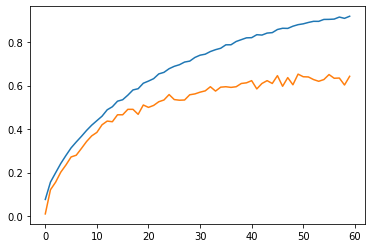

In [12]:
training_accuracy = [0.076628, 0.156130, 0.199234, 0.241895, 0.278736, 0.313660, 0.340922, 0.366637, 0.393973, 0.418288, 0.438992, 0.459549, 0.488874, 0.502947, 0.528515, 0.535220, 0.556219, 0.580239, 0.585912, 0.611111, 0.620984, 0.632110, 0.653994, 0.661141, 0.677940, 0.688918, 0.696213, 0.708518, 0.712865, 0.729664, 0.740127, 0.744695, 0.756926, 0.765473, 0.771957, 0.787798, 0.788019, 0.803124, 0.811597, 0.819923, 0.820660, 0.834291, 0.832670, 0.841807, 0.843870, 0.858238, 0.863911, 0.863322, 0.873416, 0.880489, 0.884321, 0.890657, 0.895889, 0.895741, 0.904583, 0.904878, 0.906130, 0.915488, 0.909520, 0.919246]
test_accuracy = [0.010, 0.121, 0.156, 0.202, 0.235, 0.272, 0.280, 0.311, 0.343, 0.369, 0.385, 0.420, 0.437, 0.434, 0.466, 0.466, 0.491, 0.491, 0.468, 0.511, 0.500, 0.509, 0.526, 0.534, 0.559, 0.536, 0.533, 0.534, 0.558, 0.562, 0.570, 0.576, 0.595, 0.575, 0.593, 0.595, 0.592, 0.595, 0.610, 0.613, 0.623, 0.585, 0.610, 0.623, 0.610, 0.646, 0.597, 0.637, 0.604, 0.653, 0.641, 0.640, 0.628, 0.620, 0.628, 0.651, 0.634, 0.635, 0.603, 0.643]
plt.plot(training_accuracy, label="Train Accuracy")
plt.plot(test_accuracy, label="Test Accuracy")

We can see that beyond the 40th epoch, densenet is slightly overfitted

In [ ]:
PATH = './trained_gpudensenet121v2.pth'
torch.save(trained_modelv2.state_dict(), PATH)
!cp /content/trained_gpudensenet121v2.pth /content/drive/MyDrive/trained_gpudensenet121v2v2.pth 

In [7]:
!cp /content/drive/MyDrive/trained_gpudensenet121v2.pth /content/trained_gpudensenet121v2.pth
PATH = '/content/trained_gpudensenet121v2.pth'
trained_model = torchvision.models.densenet121(pretrained=False).to(device)
trained_model.classifier = nn.Linear(1024, 100)
trained_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [13]:
params = OrderedDict(
    lr = [0.005],
    batch_size = [32],
    shuffle = [True],
)
trained_modelv2 = searching_function(params,return_model=True,network=trained_model)
PATH = './trained_gpudensenet121v3.pth'
torch.save(trained_modelv2.state_dict(), PATH)
!cp /content/trained_gpudensenet121v3.pth /content/drive/MyDrive/trained_gpudensenet121v3.pth 

# Alternative functions

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from  torchvision.datasets import ImageFolder 
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
std=torch.Tensor([0.4687, 0.4667, 0.4540])
mean=torch.Tensor([0.2792, 0.2717, 0.2852])
t_trans=T.Compose([
                 T.RandomHorizontalFlip(p=0.5),
                 T.RandomRotation(degrees=(0, 180)),
                 T.ToTensor(),
                 T.Normalize(mean,std)])
v_trans=T.Compose([
                   T.ToTensor(),
                   T.Normalize(mean,std)])
train_set=ImageFolder('./train',transform=t_trans)
valid_set=ImageFolder('./valid',transform=v_trans)
test_set=ImageFolder('./test',transform=v_trans)

In [ ]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [ ]:
import gc
batch_size = 48
num_classes = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
iterations = []
accuracies = []
losses = []
valid_set=torch.utils.data.ConcatDataset([test_set, valid_set])
# indices = torch.randperm(len(train_set))[:6000]
# train_set = Subset(train_set,indices)
# indices = torch.randperm(len(valid_set))[:600]
# valid_set = Subset(valid_set,indices)
trainloader = DataLoader(train_set, batch_size = batch_size, shuffle =  True)
testloader = DataLoader(valid_set, batch_size = batch_size, shuffle = True)

model = torchvision.models.densenet121()

for param in model.parameters():
    param.required_grad = False

model.classifier = nn.Linear(1024, num_classes)

model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

loss_epoch_arr = []
max_epochs = 25

min_loss = 1000000

n_iters = np.ceil(10436/batch_size)*max_epochs
iters = 0

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):
        iters += 1
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        del inputs, labels, outputs

        gc.collect()
        torch.cuda.empty_cache()
    loss_epoch_arr.append(loss.item())
    print('Epoch: %d/%d ended. Train acc: %0.2f' % (
      epoch+1, max_epochs, 
      evaluation(trainloader, model)))
    
print('\n\nTest Accuracy on final model: %0.4f' % evaluation(testloader, model))

Epoch: 1/25 ended. Train acc: 10.76
Epoch: 2/25 ended. Train acc: 15.37
Epoch: 3/25 ended. Train acc: 19.00
Epoch: 4/25 ended. Train acc: 21.68
Epoch: 5/25 ended. Train acc: 24.62
Epoch: 6/25 ended. Train acc: 26.44
Epoch: 7/25 ended. Train acc: 27.97
Epoch: 8/25 ended. Train acc: 30.52
Epoch: 9/25 ended. Train acc: 32.43
Epoch: 10/25 ended. Train acc: 34.93
Epoch: 11/25 ended. Train acc: 36.02
Epoch: 12/25 ended. Train acc: 37.30
Epoch: 13/25 ended. Train acc: 40.16
Epoch: 14/25 ended. Train acc: 42.33
Epoch: 15/25 ended. Train acc: 43.59
Epoch: 16/25 ended. Train acc: 44.72
Epoch: 17/25 ended. Train acc: 46.49
Epoch: 18/25 ended. Train acc: 47.23
Epoch: 19/25 ended. Train acc: 48.43
Epoch: 20/25 ended. Train acc: 51.05
Epoch: 21/25 ended. Train acc: 52.70
Epoch: 22/25 ended. Train acc: 52.66
Epoch: 23/25 ended. Train acc: 53.93
Epoch: 24/25 ended. Train acc: 55.79
Epoch: 25/25 ended. Train acc: 56.99


Test Accuracy on final model: 45.5000


In [ ]:
PATH = './trained_gpudensenet121.pth'
torch.save(model.state_dict(), PATH)
!cp /content/trained_gpudensenet121.pth /content/drive/MyDrive/trained_gpudensenet121.pth 

In [ ]:
PATH = './trained_5.pth'
read_from_file_model = torchvision.models.densenet121(pretrained=False).to(device)
read_from_file_model.classifier = nn.Linear(1024, num_classes)
# read_from_file_model.fc = nn.Sequential(nn.Flatten(),
#     nn.Linear(512, 128),
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(128, 6))
read_from_file_model.load_state_dict(torch.load(PATH))

# Explanations (in the second notebook with comparisions)

In [ ]:
!pip install scikit-image -U
!pip install shap captum torchinfo

In [3]:

import torchinfo
import shap
import captum

In [12]:
valid_set.datasets[1]

Dataset ImageFolder
    Number of datapoints: 500
    Root location: ./valid
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=tensor([0.2792, 0.2717, 0.2852]), std=tensor([0.4687, 0.4667, 0.4540]))
           )

In [20]:
!cp /content/trained_gpudensenet121v3.pth /content/drive/MyDrive/trained_gpudensenet121v3.pth 

In [ ]:
!cp /content/drive/MyDrive/trained_gpudensenet121v3.pth /content/trained_gpudensenet121v3.pth 

In [ ]:
PATH = '/content/trained_gpudensenet121v3.pth'
model_dense = torchvision.models.densenet121(pretrained=False)#.to(device)
model_dense.classifier = nn.Linear(1024, 100)
model_dense.load_state_dict(torch.load(PATH))
model_dense.eval()

In [29]:
from PIL import Image
# __X = [i[0] for i in train_set.imgs]
#  = [i[1] for i in train_set.imgs]
__X = [i[0] for i in test_set.imgs]
_y = [i[1] for i in test_set.imgs]
__X = __X[:125]
_y = _y[:125]
len(__X)

125

In [30]:
import gc
gc.collect()
torch.cuda.empty_cache()
_X = []
y = []

convert_tensor = torchvision.transforms.ToTensor()
for i,pth in enumerate(__X):
  if i%25 == 0:
    gc.collect()
    torch.cuda.empty_cache()
  img = Image.open(pth)
  img_tens = convert_tensor(img)
  if img_tens.size() == torch.Size([3, 224, 224]):
    _X.append(img_tens)
    y.append(_y[i])
_X = torch.stack((_X))


In [31]:
gc.collect()
torch.cuda.empty_cache()
y = torch.as_tensor(y)
# _X = _X / 255

In [12]:
gc.collect()
torch.cuda.empty_cache()
preprocess = torchvision.transforms.Compose([
   torchvision.transforms.Normalize(
       mean=[0.2792, 0.2717, 0.2852],
       std=[0.4687, 0.4667, 0.4540]
   )
])
gc.collect()
torch.cuda.empty_cache()

In [22]:
torch.save(_X,'./x_set_gpu.pt')
torch.save(y,'./y_set_gpu.pt')

In [6]:
!cp /content/x_set_gpu.pt /content/drive/MyDrive/x_set_gpu.pt
!cp /content/y_set_gpu.pt /content/drive/MyDrive/y_set_gpu.pt

In [ ]:
!cp /content/drive/MyDrive/y_set_gpu.pt /content/y_set_gpu.pt
!cp /content/drive/MyDrive/x_set_gpu.pt /content/x_set_gpu.pt

In [5]:
_X = torch.load('./x_set_gpu.pt')
y = torch.load('./y_set_gpu.pt')

In [23]:
X = torch.movedim(_X, 3, 1)

In [33]:
gc.collect()
torch.cuda.empty_cache()
torch.nn.functional.softmax(model_dense(preprocess(_X)), dim=1).argmax(axis=1)

tensor([ 0,  0,  0,  0, 19,  1, 90,  1,  1,  1,  2, 63,  2,  2,  2,  3,  3,  3,
        50, 83,  2,  4,  4,  4,  4,  5,  5,  5,  5, 52,  6,  4, 82,  6,  6, 21,
        21,  7,  7,  7, 71,  8,  8,  8,  8, 94,  9, 63, 49, 36, 10,  8, 10, 98,
        70, 11, 11, 11, 11, 11,  2, 33, 12, 12, 12, 13, 13, 31, 13, 81, 14,  9,
        74, 14, 14, 15, 15, 15, 15, 15, 16, 16, 42, 16, 16, 17, 17, 17, 89, 17,
        18, 18, 18, 18, 18, 19, 90, 19, 19, 16, 20, 20, 20, 20, 20, 21, 21, 21,
        21, 21, 22, 22, 22, 36, 22, 81, 23, 23, 23, 23, 24, 24, 36, 24, 21])

In [ ]:
gc.collect()
torch.cuda.empty_cache()
torchinfo.summary(model_dense, input_size=_X.shape)

In [35]:
val_ld = DataLoader(valid_set)
labels = None
for i,batch in enumerate(val_ld):
  _,label = batch
  if i == 0:
    labels = torch.tensor(label)
  else:
    labels = torch.cat((labels,label))
  i+=1
@torch.no_grad()
def get_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch

    preds = model(images)
    all_preds = torch.cat((all_preds, preds) ,dim=0)

  return all_preds
test_loader = DataLoader(valid_set, batch_size = 64,num_workers=4)
test_preds = get_preds(model_dense, test_loader)
gc.collect()
torch.cuda.empty_cache()
# actual_labels = pd.read_csv('./sports.csv')
actual_labels = labels
preds_correct = test_preds.argmax(dim=1).eq(actual_labels).sum().item()

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(valid_set))

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


total correct: 699
accuracy: 0.699


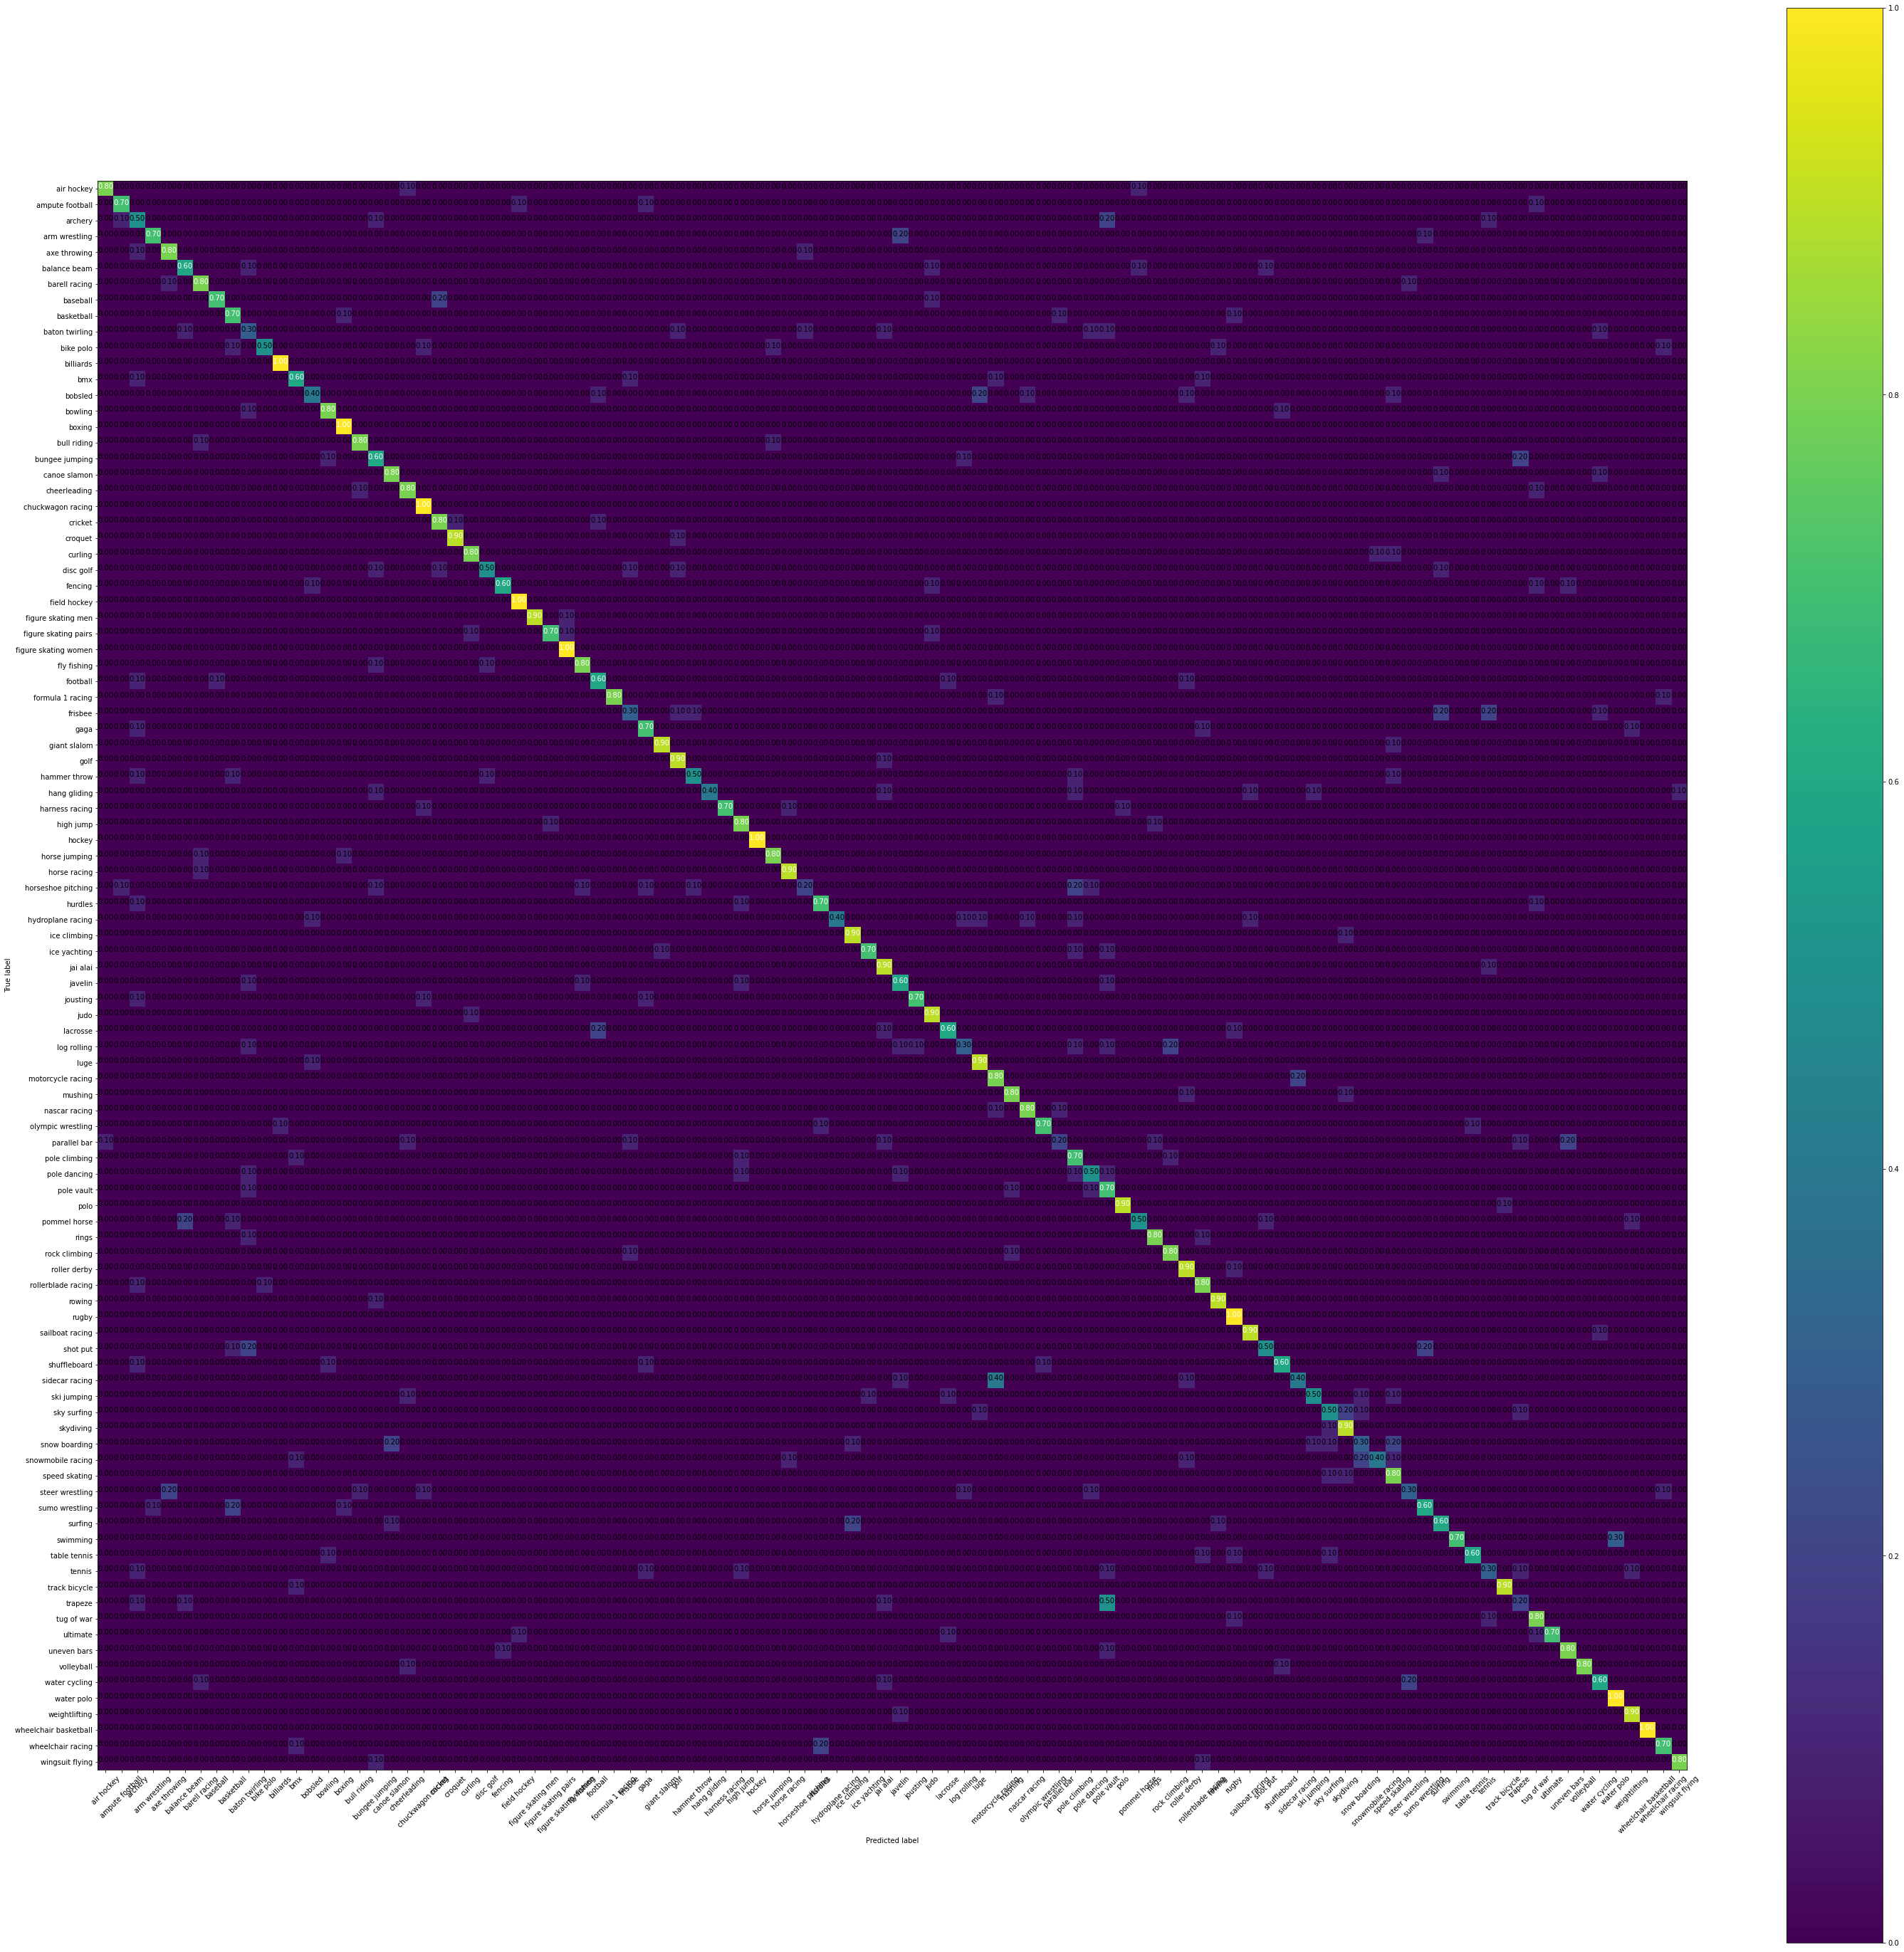

In [36]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    gc.collect()
    torch.cuda.empty_cache()
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

classes = train_set.classes
plt.figure(figsize = (50,50))

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
cm = confusion_matrix(labels, test_preds.argmax(dim=1))
plot_confusion_matrix(cm, classes)
# classes = labels
# plt.figure(figsize=(60,60))
# plot_confusion_matrix(cm, labels,title='Confusion matrix on test set')

In [10]:
import PIL
import gc
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
def show_images(images, k = 3): 
    fig, ax = plt.subplots(k, 2, figsize=[6 * k, 6 * k])
    my_dict2 = {y:x for x,y in test_set.class_to_idx.items()}
    batch_size=1
    gc.collect()
    torch.cuda.empty_cache()
    # ld=DataLoader(images,batch_size,num_workers=2,pin_memory=True)
    y_hat = torch.nn.functional.softmax(model_dense(preprocess(images)), dim=1)
    preds = y_hat.amax(axis=1)
    preds_idx = y_hat.argmax(axis=1)
    print(preds)
    print(preds_idx)
    for i, image in enumerate(images):
        # image,_ = image
        pred = preds[i].item()
        pred_idx = preds_idx[i].item()
        # plt.figure(figsize=(16,16))
        ax[i%k, i//k].imshow(image.permute(1, 2, 0))
        ax[i%k, i//k].set_title(f"{pred_idx}: {my_dict2[pred_idx]} ({round(pred, 3)})")
        ax[i%k, i//k].axis('off')

In [ ]:
batch_size=1
#train_ld=DataLoader(train_set,batch_size,shuffle=True,num_workers=2,pin_memory=True)
val_ld=DataLoader(valid_set,batch_size,num_workers=4,pin_memory=True)
from torchvision.utils import make_grid

def show_batch(loader):
    for img,_ in loader:
        plt.figure(figsize=(16,16))
        plt.imshow(make_grid(img,16).permute(1,2,0))
        break


show_batch(val_ld)

tensor([0.9969, 0.2497, 0.4751, 0.6554, 0.6187, 0.9827],
       grad_fn=<AmaxBackward0>)
tensor([ 7, 71,  8,  8,  8,  8])


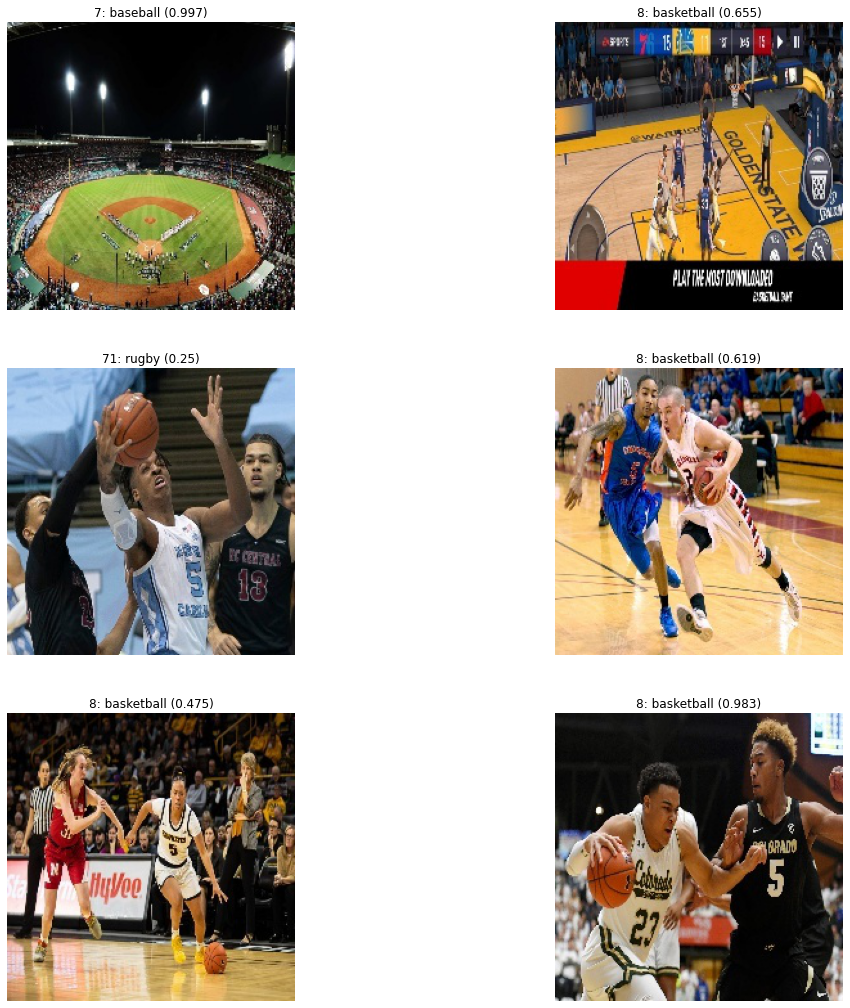

In [13]:
show_images(_X[39:45], k=3)

In [14]:
def plot_photo(img):
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.imshow(img.cpu().permute([1,2,0]).squeeze())
    plt.show()
def show_image_mask_explanation(image, mask, explanation):
    fig, ax = plt.subplots(1, 3, figsize=[6 * 2, 6])
    ax[0].imshow(image.permute(1, 2, 0))
    ax[0].set_title("image")
    ax[1].imshow(mask, cmap="flag")
    ax[1].set_title("segmentation mask")
    ax[2].imshow(explanation, vmin=-1, vmax=1, cmap="RdBu")
    ax[2].set_title("explanation")
    plt.show()

In [15]:
from captum.attr import Lime
from skimage import segmentation
from captum.attr import visualization
from captum.attr import IntegratedGradients
explainer = Lime(model_dense)
def lime_explanation(idx,targ):
  mask = segmentation.slic(
      _X[idx].permute(1, 2, 0).mean(axis=2), 
      n_segments=100, 
      compactness=0.1, 
      start_label=0,
    )
  mask = segmentation.quickshift(
      _X[idx].permute(1, 2, 0), 
      kernel_size=14, 
      max_dist=7, 
      ratio=0.5
    )
  attr = explainer.attribute(
      preprocess(_X[idx].unsqueeze(0)), 
      target=targ, 
      n_samples=200, 
      feature_mask=torch.as_tensor(mask),
      show_progress=True
    )
  show_image_mask_explanation(_X[idx], mask, attr[0].mean(axis=0))

def show_attr(idx,targ,attr=None):
    mask = segmentation.quickshift(
      _X[idx].permute(1, 2, 0), 
      kernel_size=14, 
      max_dist=7, 
      ratio=0.5
    )
    if attr is None:
      attr = explainer.attribute(
        preprocess(_X[idx].unsqueeze(0)), 
        target=targ, 
        n_samples=200, 
        feature_mask=torch.as_tensor(mask),
        show_progress=True
      )
    attr_map = attr[0]
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True
    )
def show_igs(idx,targ):
  exp_ig = IntegratedGradients(model_dense)
  attr_ig = exp_ig.attribute(preprocess(_X[idx].unsqueeze(0)), target=targ)
  show_attr(idx,targ,attr_ig)


In [16]:
from captum.attr import KernelShap


def show_shap(idx,targ):
  ks = KernelShap(model_dense)
  mask = segmentation.quickshift(
        _X[idx].permute(1, 2, 0), 
        kernel_size=14, 
        max_dist=7, 
        ratio=0.5
      )
  attr_ks = explainer.attribute(
      preprocess(_X[idx].unsqueeze(0)), 
      target=targ, 
      n_samples=200, 
      feature_mask=torch.as_tensor(mask),
      show_progress=True
    )

  show_attr(idx,targ,attr=attr_ks)


def show_shap_deep(idx,num_classes=2):
  exp_deep = shap.DeepExplainer(model_dense, data=preprocess(_X))
  gc.collect()
  torch.cuda.empty_cache()
  sv_deep, idx_deep = exp_deep.shap_values(preprocess(_X[idx:idx+1]), ranked_outputs=num_classes)
  idx_to_labels = {y:x for x,y in test_set.class_to_idx.items()}
  gc.collect()
  torch.cuda.empty_cache()
  shap.image_plot(
    [sv.squeeze(0).transpose((1, 2, 0)) for sv in sv_deep], 
    _X[idx].permute(1, 2, 0).numpy(), 
    np.vectorize(lambda x: idx_to_labels[x])(idx_deep)
  )


def show_shap_gradient(idx,num_classes=2):
  class NetWrapper(torch.nn.Module):
    def __init__(self, model, preprocess):
        super(NetWrapper, self).__init__()
        self.preprocess = preprocess
        self.model = model
    def forward(self, x):
        x = self.preprocess(x)
        x = self.model(x)
        x = torch.nn.functional.softmax(x, dim=1)
        return x

  model_wrapper = NetWrapper(model_dense, preprocess)
  exp_gradient = shap.GradientExplainer(model_wrapper, data=_X)
  gc.collect()
  torch.cuda.empty_cache()
  sv_gradient, idx_gradient = exp_gradient.shap_values(_X[idx:idx+1], ranked_outputs=num_classes)
  idx_to_labels = {y:x for x,y in test_set.class_to_idx.items()}
  gc.collect()
  torch.cuda.empty_cache()
  shap.image_plot(
    [sv.squeeze(0).transpose((1, 2, 0)) for sv in sv_gradient], 
    _X[idx].permute(1, 2, 0).numpy(), 
    np.vectorize(lambda x: idx_to_labels[x])(idx_gradient)
  )

In [17]:
idx_to_labels = {y:x for x,y in test_set.class_to_idx.items()}

# Photo 1

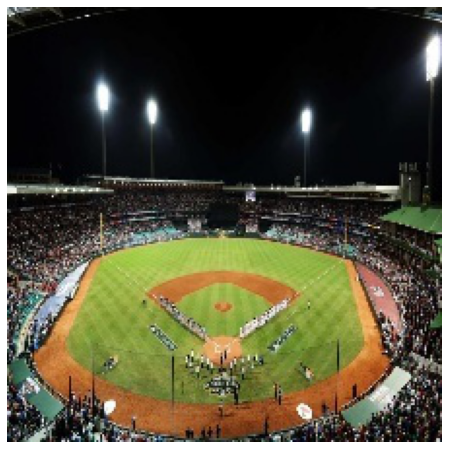

In [18]:
plot_photo(_X[39])

In [19]:
idx_to_labels[y[39].item()] # correct prediction

'baseball'

Lime attribution: 100%|██████████| 200/200 [00:19<00:00, 10.31it/s]


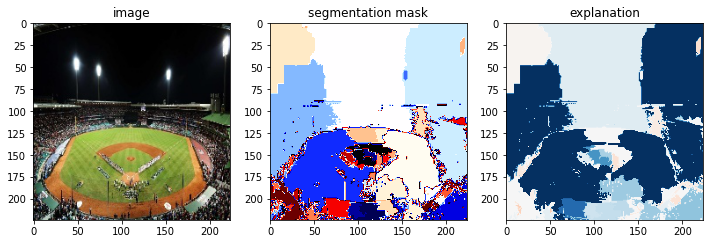

In [46]:
gc.collect()
torch.cuda.empty_cache()
lime_explanation(39,7)

Lime attribution: 100%|██████████| 200/200 [00:19<00:00, 10.49it/s]


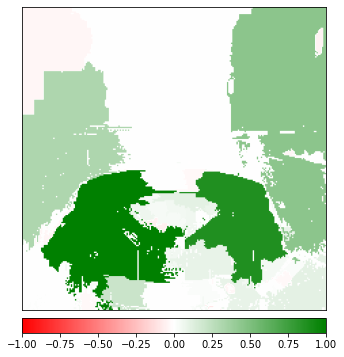

In [47]:
gc.collect()
torch.cuda.empty_cache()
show_attr(39,7)

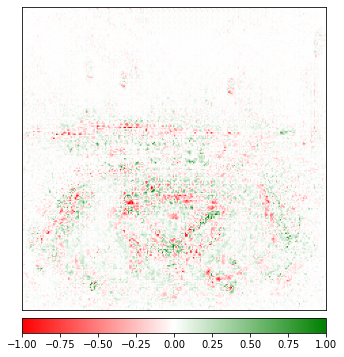

In [48]:
gc.collect()
torch.cuda.empty_cache()
show_igs(39,7)

Lime attribution: 100%|██████████| 200/200 [00:19<00:00, 10.40it/s]


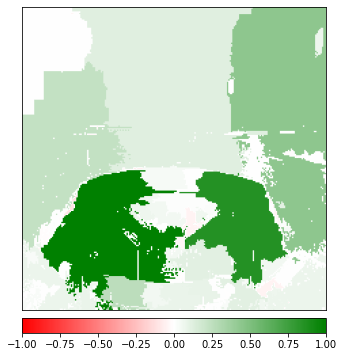

In [49]:
gc.collect()
torch.cuda.empty_cache()
show_shap(39,7)